In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

In [2]:
# data transform
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = 'Data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [4]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [5]:
class_names

['COVID-19', 'Normal', 'Pnemonia_others', 'non-COVID-19']

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_acc = []
    valid_acc = []
    train_loss = []
    valid_loss = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, train_loss, valid_acc, valid_loss

In [9]:
inception_v3 = models.inception_v3(pretrained=True)


In [10]:
inception_v3.aux_logits = False
num_classes = len(class_names)
for param in inception_v3.parameters():
    param.requires_grad = False
num_ftrs = inception_v3.fc.in_features
inception_v3.fc = nn.Linear(num_ftrs, num_classes)

In [11]:
inception_v3

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [12]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Observe that all parameters are being optimized
optimizer = optim.SGD(inception_v3.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [13]:
inception_v3,train_acc, train_loss, valid_acc, valid_loss = train_model(inception_v3, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0841 Acc: 0.5254
val Loss: 0.8356 Acc: 0.6743

Epoch 1/24
----------
train Loss: 0.9754 Acc: 0.5803
val Loss: 0.8329 Acc: 0.7051

Epoch 2/24
----------
train Loss: 0.9966 Acc: 0.5787
val Loss: 0.8687 Acc: 0.6477

Epoch 3/24
----------
train Loss: 0.9885 Acc: 0.5774
val Loss: 0.8165 Acc: 0.6589

Epoch 4/24
----------
train Loss: 0.9896 Acc: 0.5874
val Loss: 0.8138 Acc: 0.6833

Epoch 5/24
----------
train Loss: 0.9762 Acc: 0.5833
val Loss: 0.7724 Acc: 0.7024

Epoch 6/24
----------
train Loss: 0.9481 Acc: 0.6013
val Loss: 0.7833 Acc: 0.6939

Epoch 7/24
----------
train Loss: 0.9609 Acc: 0.5931
val Loss: 0.8188 Acc: 0.6897

Epoch 8/24
----------
train Loss: 0.9491 Acc: 0.5967
val Loss: 0.7630 Acc: 0.7327

Epoch 9/24
----------
train Loss: 0.9872 Acc: 0.5867
val Loss: 0.7281 Acc: 0.7375

Epoch 10/24
----------
train Loss: 0.9815 Acc: 0.5876
val Loss: 0.7413 Acc: 0.7078

Epoch 11/24
----------
train Loss: 0.9603 Acc: 0.5938
val Loss: 0.7571 Acc: 0.7088

Ep

In [15]:
predicted = []
labels = []
for data, label in dataloaders["val"]:
    outputs = inception_v3(data)
    _, preds = torch.max(outputs, 1)
    labels.extend(label.tolist())
    predicted.extend(preds.tolist())
print(len(predicted))
print(len(labels))

1882
1882


In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
print(classification_report(labels, predicted, target_names=class_names))
cmf = confusion_matrix(labels,predicted,normalize="true")
cmf = pd.DataFrame(cmf, 
  index = class_names,
  columns = class_names)

                 precision    recall  f1-score   support

       COVID-19       0.73      0.62      0.67       112
         Normal       0.82      0.82      0.82       479
Pnemonia_others       0.69      0.44      0.54       451
   non-COVID-19       0.72      0.86      0.78       840

       accuracy                           0.74      1882
      macro avg       0.74      0.69      0.70      1882
   weighted avg       0.74      0.74      0.73      1882



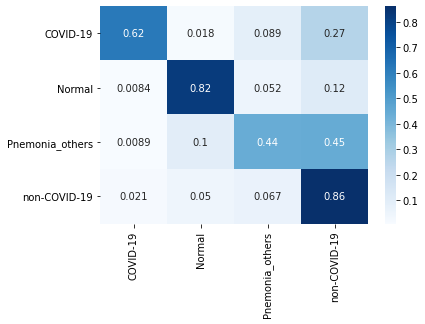

In [17]:
sns.heatmap(cmf, cmap='Blues',annot=True)